In [197]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
sc.settings.verbosity = 3

In [198]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [199]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import scSpaMet as spamet

In [201]:
experiment = "tonsil"
cores = ["DonorA", "DonorE"]
datasets = [core + f"_{i}" for i in range(1, 7) for core in cores]

# Load data

In [202]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [203]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [204]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [205]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

In [206]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
# mz_qc = df_sum[(df_sum > 16000)].index.tolist()
mz_qc = df_sum[(df_sum > 220)].index.tolist()

In [207]:
len(mz_qc)

197

In [208]:
adata = adata[:, mz_qc]
adata_raw = adata_raw[:, mz_qc]

In [209]:
# Define IMC and SIMS marker list
IMC_markers = adata.var_names.tolist()
SIMS_masses = adata_IMC.var_names.tolist()

# Joint embedding

In [210]:
def Umap(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.pp.neighbors(a,use_rep=rep, metric='cosine')
    else:
        sc.pp.neighbors(a)
    sc.tl.umap(a)
    print('Sucessfully run Umap!')
    return a

def TSNE(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.tl.tsne(a,use_rep=rep)
    else:
        sc.tl.tsne(a)
    print('Sucessfully run TSNE!')
    return a

In [211]:
train_x_IMC = adata_IMC.X
train_x_SIMS = adata.X

In [212]:
train_x_IMC.shape

(31156, 16)

In [213]:
train_x_SIMS.shape

(31156, 197)

In [214]:
# # X_embedding, _, _ = spamet.tl.Joint_XVAE_clustering(train_x_IMC, train_x_SIMS, epochs=20)
# X_embedding, q, X_predict = spamet.tl.Joint_XVAE_clustering(train_x_IMC, train_x_SIMS, epochs=100, resolution=0.3, latent_dim=16, netwidths_1=[16,8,8], netwidths_2=[128,64,32,16])

In [215]:
X_embedding, q, X_predict

NameError: name 'X_embedding' is not defined

# Clustering

In [ ]:
y_pred=pd.Series(np.argmax(q,axis=1),index=adata.obs.index)
# y_pred.cat.categories=list(range(len(y_pred.unique())))

In [ ]:
adata.obsm['Joint'] = X_embedding[2]

In [ ]:
Umap(adata,rep='Joint')


In [ ]:
adata.obs['leiden'] = y_pred.astype(str)
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

In [ ]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["Dataset"], size=10)

In [ ]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["leiden"], size=10)

In [ ]:
TSNE(adata,rep='Joint')

In [ ]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.tsne(adata, color=["leiden"], size=10)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test_overestim_var')


In [ ]:
sns.set_context("notebook", font_scale=1.4)

dp_object =  sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden', standard_scale='obs', cmap='bwr', 
                                             dendrogram=True, figsize=(15, 15), show_gene_labels=True, 
                                             swap_axes=True)

In [ ]:
dedf = sc.get.rank_genes_groups_df(adata, group=None)
# Get top diff expression
topk=7
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [ ]:
adata_subset = adata[:, masses]

In [ ]:
sc.pl.heatmap(
    adata_subset,
    adata_subset.var_names.tolist(),
    'leiden',
    dendrogram=True,
    cmap='bwr',
    figsize=(10, 10),
    standard_scale='obs',
    log=False,
    show_gene_labels=True
)



# Viz

In [ ]:
adata_IMC.obs['leiden_joint'] = adata.obs['leiden']

In [ ]:
sc.tl.dendrogram(adata_IMC, 'leiden_joint')
sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    'leiden_joint',
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
    standard_scale='var'
)

In [ ]:
sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    'leiden_joint',
    dendrogram=True,
    colorbar_title="Mean expression",
    cmap="RdBu_r", 
    swap_axes=True,
)

In [ ]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=['leiden_joint'], size=10)

In [ ]:
import matplotlib 
cluster_label_order = adata_IMC.uns['dendrogram_leiden_joint']['categories_ordered']

colors = adata_IMC.uns["leiden_joint_colors"]
labels = adata_IMC.obs.leiden.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

In [ ]:
# legend
fig, ax = plt.subplots(figsize=(8,0.7))
ax.bar(x=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.xticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=20)
_ = plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(False)
plt.show()

# Spatial neighborhood clustering

In [216]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

def get_NN(adata, n):
    data = adata.obsm["spatial"]
    fit = NearestNeighbors(n_neighbors=n+1).fit(data)
    m = fit.kneighbors(data)
    # m = m[0], m[1] # Distances, Indices
    m = m[0][:, 1:], m[1][:, 1:]
    
    # sort_neighbors
    args = m[0].argsort(axis=1)
    add = (
        np.arange(m[1].shape[0]) * m[1].shape[1]
    )  # arange for number of elements with step of number of neighbors
    sorted_indices = m[1].flatten()[
        args + add[:, None]
    ]  # Extract indices in sorted order
    return sorted_indices

def get_NN_radius(adata, r):
    data = adata.obsm["spatial"]
    fit = NearestNeighbors(radius=r).fit(data)
    m = fit.radius_neighbors(data, return_distance=False)
    
    # Put in dataframe format
    neighbours = pd.DataFrame(m.tolist(), index = adata.obs.index)
    return neighbours

def neighbor_frequency(adata, n=10, radius=25, var='clusters', radius_type='radius'):
    dummies = pd.get_dummies(adata.obs[var])
    values = dummies.values
    
    if radius_type == 'radius':
        phenomap = dict(zip(list(range(len(adata))), adata.obs[var].tolist()))
        neighbours=get_NN_radius(adata, radius)
        for i in neighbours.columns:
            neighbours[i] = neighbours[i].dropna().map(phenomap, na_action='ignore')
        neighbours = neighbours.dropna(how='all') # This is the class of neighbors
        window = neighbours.stack().str.get_dummies().groupby(level=0).sum()
        window = neighbours.stack().str.get_dummies().groupby(level=0).sum()
        window = window.div(window.sum(axis=1), axis=0)
        window = window.loc[adata_subset.obs.index]
    else:
        cols = get_NN(adata, n)
        window = values[cols].flatten()
        window = window.reshape(-1, n, dummies.shape[1])
        window = window.sum(axis=1) / n
        window = pd.DataFrame(window, columns=dummies.columns.tolist())
    assert len(window) == len(adata.X)
    return window

In [217]:
path = data_dir / "adata"  / f'{experiment}_vae.h5ad' 
adata = ad.read_h5ad(path)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [218]:
adata.obs

,Cell,Dataset,Core,leiden
0,1,DonorA_1,DonorA,4
1,2,DonorA_1,DonorA,8
2,3,DonorA_1,DonorA,8
3,4,DonorA_1,DonorA,8
4,5,DonorA_1,DonorA,8
...,...,...,...,...
31151,3002,DonorE_6,DonorE,0
31152,3003,DonorE_6,DonorE,9
31153,3004,DonorE_6,DonorE,1
31154,3005,DonorE_6,DonorE,1


In [257]:
n_neighbors = 20
r = 15
windows = []
var='leiden'

# Loop to get window size 
for d in adata.obs.Dataset.unique():
    print(d)
    adata_subset = adata[adata.obs.Dataset == d, :]
    print(len(adata_subset))
    # sq.gr.spatial_neighbors(adata_subset, n_neighs=n_neighbors)
    window = neighbor_frequency(adata_subset, n=n_neighbors, var=var, radius=r)
    assert len(window) == len(adata_subset.X)

    windows.append(window)

window = pd.concat(windows)
window = window.fillna(0)
window.shape

DonorA_1
2711
DonorE_1
3401
DonorA_2
3047
DonorE_2
2941
DonorA_3
2107
DonorE_3
3037
DonorA_4
2885
DonorE_4
3150
DonorA_5
2540
DonorE_5
2331
DonorE_6
3006


(31156, 12)

In [258]:
window.isna().values.any()

False

In [259]:
adata.obs['leiden'].unique()

['4', '8', '7', '10', '2', ..., '1', '11', '0', '9', '5']
Length: 12
Categories (12, object): ['0', '1', '10', '11', ..., '6', '7', '8', '9']

## CN clustering

In [260]:
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator

In [261]:
adata_CN = ad.AnnData(window)
adata_CN.raw = adata.copy()
adata_CN.obs = adata.obs.copy()
adata_CN.uns = adata.uns.copy()
adata_CN.obsm = adata.obsm.copy()
adata_CN.obsp = adata.obsp.copy() 
adata_CN.var_names = window.columns.tolist()

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NU

The suggested number of clusters =  11


C:\Users\thu71\AppData\Local\Temp\ipykernel_16708\1178085993.py:30: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))


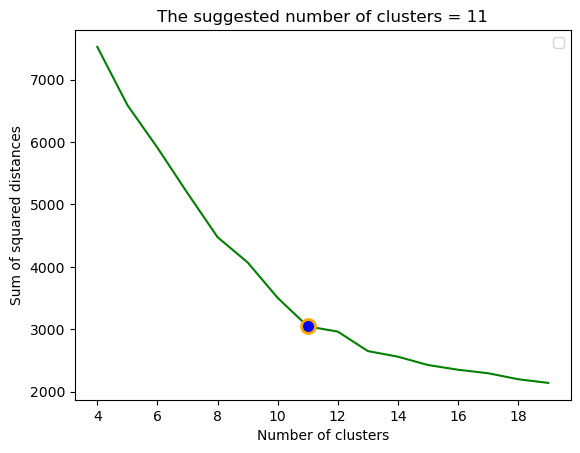

In [262]:
proj_3d = adata_CN.X

n_components = np.arange(4,20, step=1)
models = [
    MiniBatchKMeans(random_state=5, n_clusters=n, n_init=3).fit(proj_3d) for n in n_components
]

BIC_Scores = [m.inertia_ for m in models]
kneedle_point = KneeLocator(
    n_components, BIC_Scores, curve="convex", direction="decreasing"
)
print("The suggested number of clusters = ", kneedle_point.knee)
Elbow_idx = np.where(BIC_Scores == kneedle_point.knee_y)[0]

plt.plot(
    n_components,
    BIC_Scores,
    "-g",
    marker="o",
    markerfacecolor="blue",
    markeredgecolor="orange",
    markeredgewidth="2",
    markersize=10,
    markevery=Elbow_idx,
)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc="best")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))
plt.show()

In [265]:
n_neighborhoods = 9

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

labels = km.fit_predict(adata_CN.X)
k_centroids = km.cluster_centers_

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [266]:
sc.tl.dendrogram(adata, 'leiden')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


In [267]:
adata.obs

,Cell,Dataset,Core,leiden
0,1,DonorA_1,DonorA,4
1,2,DonorA_1,DonorA,8
2,3,DonorA_1,DonorA,8
3,4,DonorA_1,DonorA,8
4,5,DonorA_1,DonorA,8
...,...,...,...,...
31151,3002,DonorE_6,DonorE,0
31152,3003,DonorE_6,DonorE,9
31153,3004,DonorE_6,DonorE,1
31154,3005,DonorE_6,DonorE,1


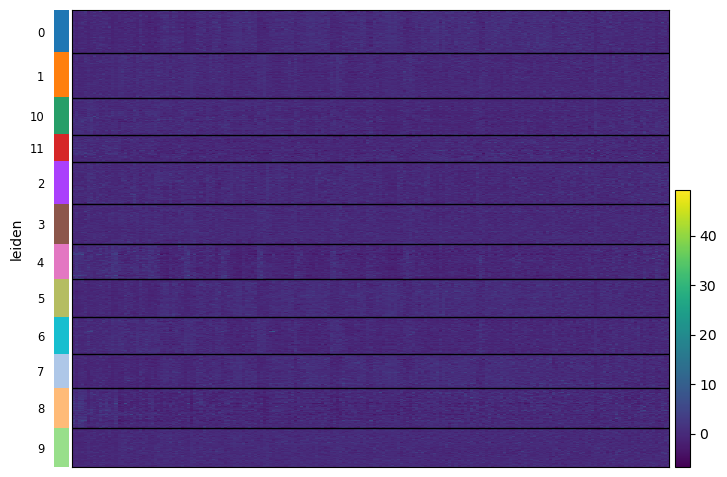

In [268]:
sc.pl.heatmap(adata, adata.var_names,groupby='leiden')

## Merge clusters based on dendrogram

In [269]:
import matplotlib

In [270]:
labels = np.array(km.fit_predict(adata_CN.X)).astype(str)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [271]:
adata_CN.obs['CN']  = labels
adata_CN.obs["CN"] = adata_CN.obs["CN"].astype("category")
adata_CN.uns["CN_colors"] = sc.pl.palettes.vega_20[:len(np.unique(adata_CN.obs['CN']))]

# Reorder cat
clusters = np.unique(adata_CN.obs["CN"]).tolist()
clusters.sort(key=int)
adata_CN.obs["CN"] = adata_CN.obs["CN"].cat.reorder_categories(clusters)

In [272]:
var = 'leiden'

In [273]:
df_cluster = pd.DataFrame()
df_cluster["Clusters"] = labels
df_cluster["Clusters"] = df_cluster["Clusters"].astype(str).astype('category')
df_cluster["Leiden"] = adata_CN.obs[var].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()

df_cluster_count['Density'] = df_cluster_count["counts"] / df_cluster_count.groupby('Clusters')['counts'].transform('sum')

clusters = df_cluster["Clusters"].unique().tolist()
clusters.sort(key=int)

In [274]:
cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

In [275]:
adata.obs['leiden'].unique()

['4', '8', '7', '10', '2', ..., '1', '11', '0', '9', '5']
Length: 12
Categories (12, object): ['0', '1', '10', '11', ..., '6', '7', '8', '9']

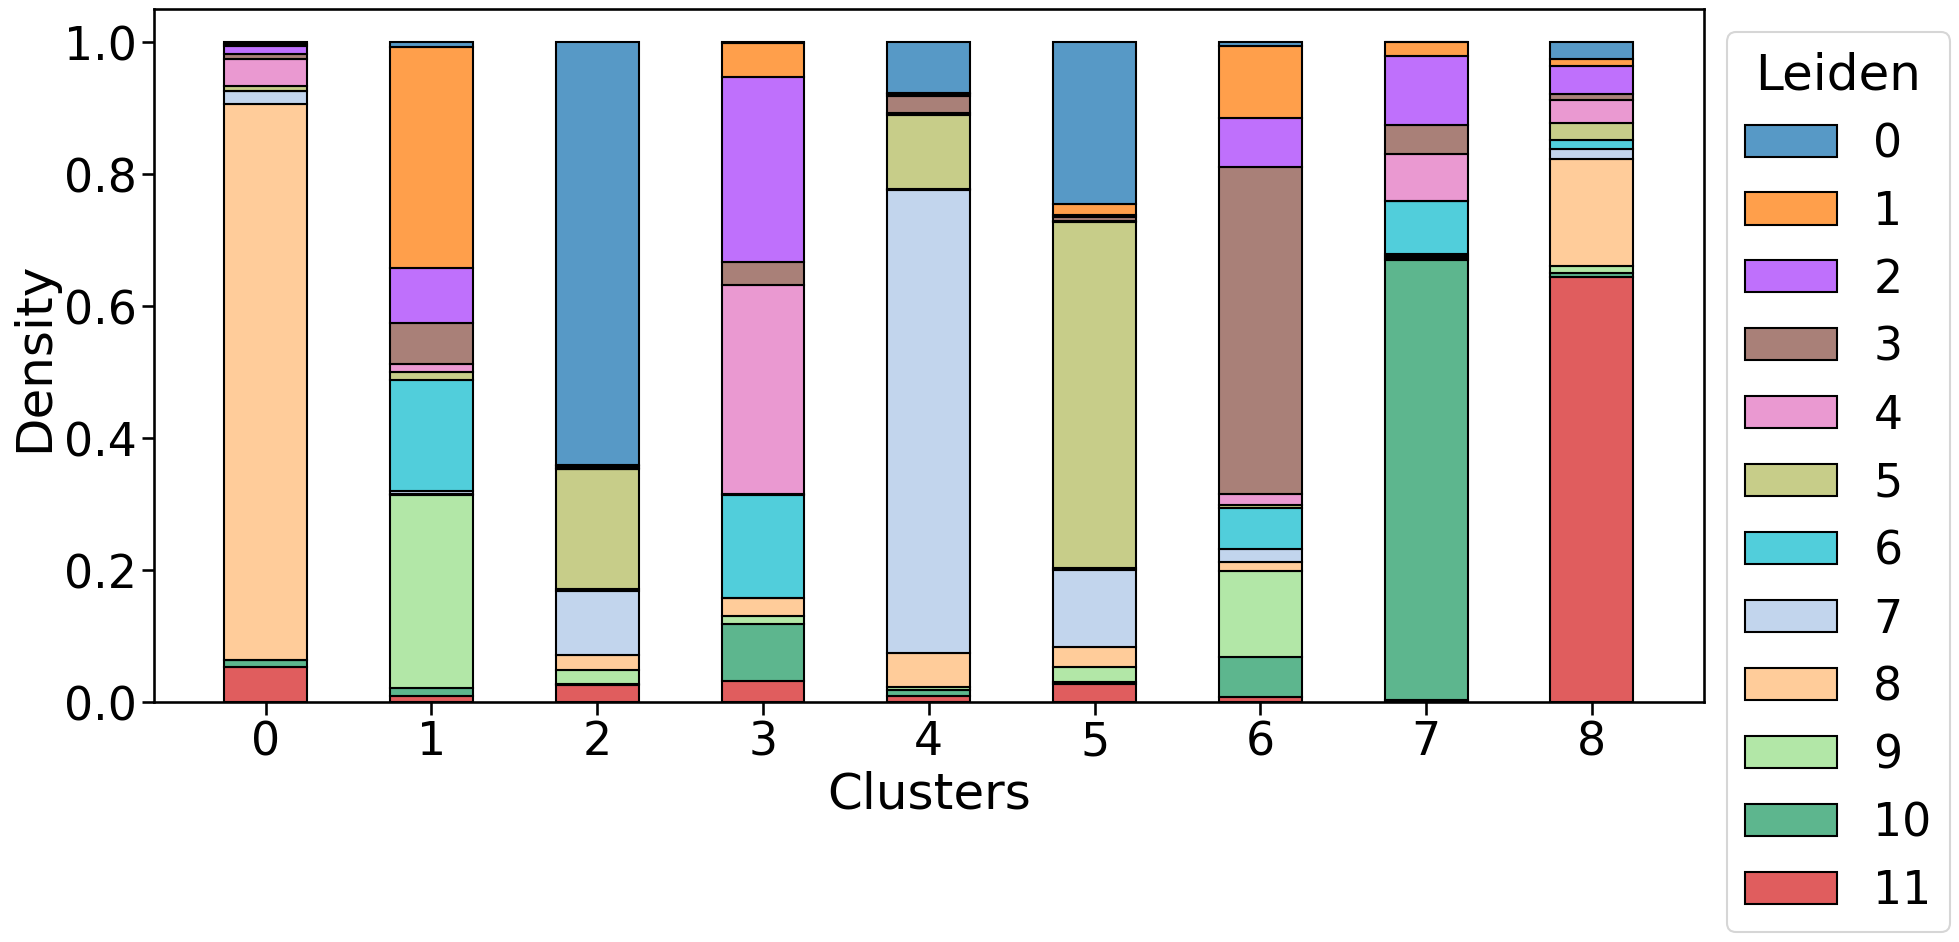

In [276]:
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(20, 9))
    ax = sns.histplot(data=df_cluster_count, x='Clusters' , hue='Leiden', weights='Density', discrete=True, multiple='stack', shrink=0.5, palette=colors_rgb_dict, edgecolor='k', 
                     hue_order=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', ])
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))


In [277]:
# Plot count
df_count = (
 df_cluster_count.loc[:,['Clusters', 'Leiden', 'Density']]
 .pivot(index='Clusters', columns='Leiden')
 .fillna(0)
 .droplevel(0, axis=1)
)

adata_count = sc.AnnData(df_count.values)
adata_count.var_names = df_count.columns.tolist()
adata_count.obs['Clusters'] = df_count.index.tolist()
adata_count.obs['Clusters'] = adata_count.obs['Clusters'].astype('category')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Clusters']`


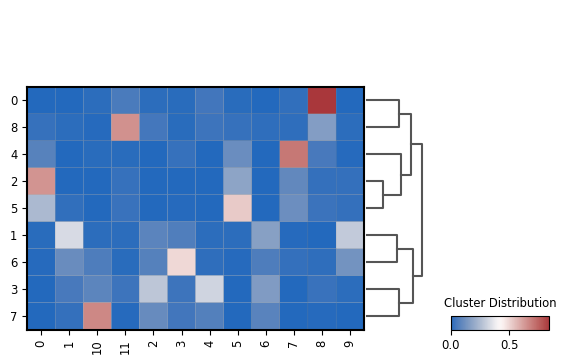

In [304]:
sc.tl.dendrogram(adata_count, 'Clusters')

sc.pl.matrixplot(
    adata_count,
    adata_count.var_names.tolist(),
    "Clusters",
    dendrogram=True,
    colorbar_title="Cluster Distribution",
    cmap="vlag",
    use_raw=False,
    # standard_scale='var'
)

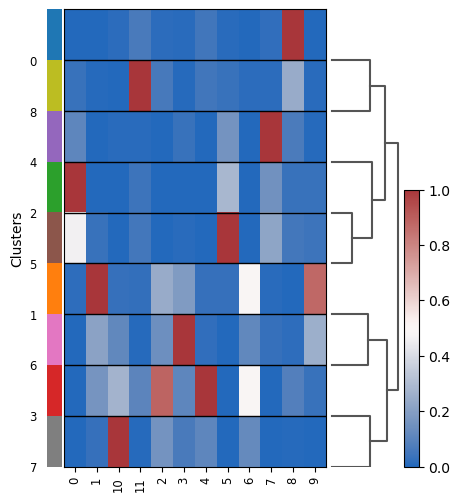

In [279]:
sc.pl.heatmap(
    adata_count,
    adata_count.var_names.tolist(),
    "Clusters",
    dendrogram=True,
    cmap="vlag",
    use_raw=False,
    standard_scale='obs'
)

In [300]:
donors = adata_CN.obs.Dataset.unique()
dfs = []

for donor in donors:
    adata_subset = adata_CN[adata_CN.obs.Dataset == donor,:]
    
    # Summary of the phenotyping
    
    df = pd.DataFrame(adata_subset.obs['CN'].value_counts())
    df.columns=[donor]
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)
df = df.fillna(0)

In [301]:
df.to_clipboard()

In [302]:
adata_count_dataset = sc.AnnData(df.values)
adata_count_dataset.var_names = df.columns.tolist()
adata_count_dataset.obs['CN'] = df_count.index.tolist()
adata_count_dataset.obs['CN'] = adata_count_dataset.obs['CN'].astype('category')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_CN']`


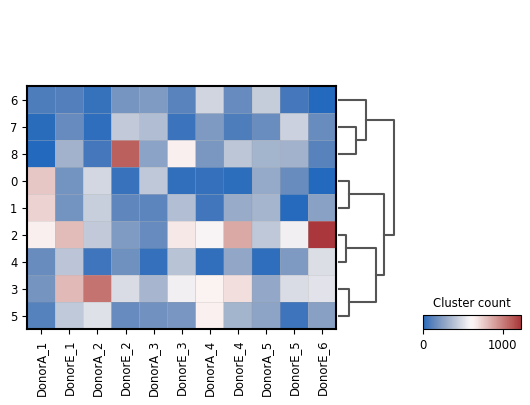

In [303]:
sc.tl.dendrogram(adata_count_dataset, 'CN')

sc.pl.matrixplot(
    adata_count_dataset,
    adata_count_dataset.var_names.tolist(),
    "CN",
    colorbar_title="Cluster count",
    cmap="vlag",
    use_raw=False,
    dendrogram=True,
)

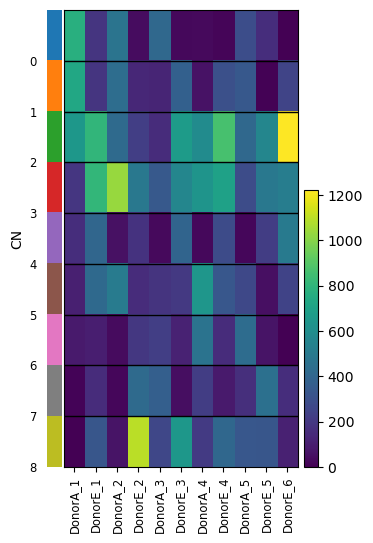

In [284]:
sc.pl.heatmap(adata_count_dataset,adata_count_dataset.var_names.tolist(),
    "CN", )

In [285]:
df_cluster = pd.DataFrame()
df_cluster["CN"] = adata_CN.obs.CN.tolist()
df_cluster["CN"] = df_cluster["CN"].astype(str).astype('category')
df_cluster["Follicle"] = adata_CN.obs['Dataset'].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()

df_cluster_count['Density'] = df_cluster_count["counts"] / df_cluster_count.groupby('Follicle')['counts'].transform('sum')

clusters = df_cluster["CN"].unique().tolist()
clusters.sort(key=int)

In [286]:
var = 'CN'
cluster_label_order =  adata_count_dataset.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_count_dataset.uns[f"{var}_colors"]
labels = adata_count_dataset.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

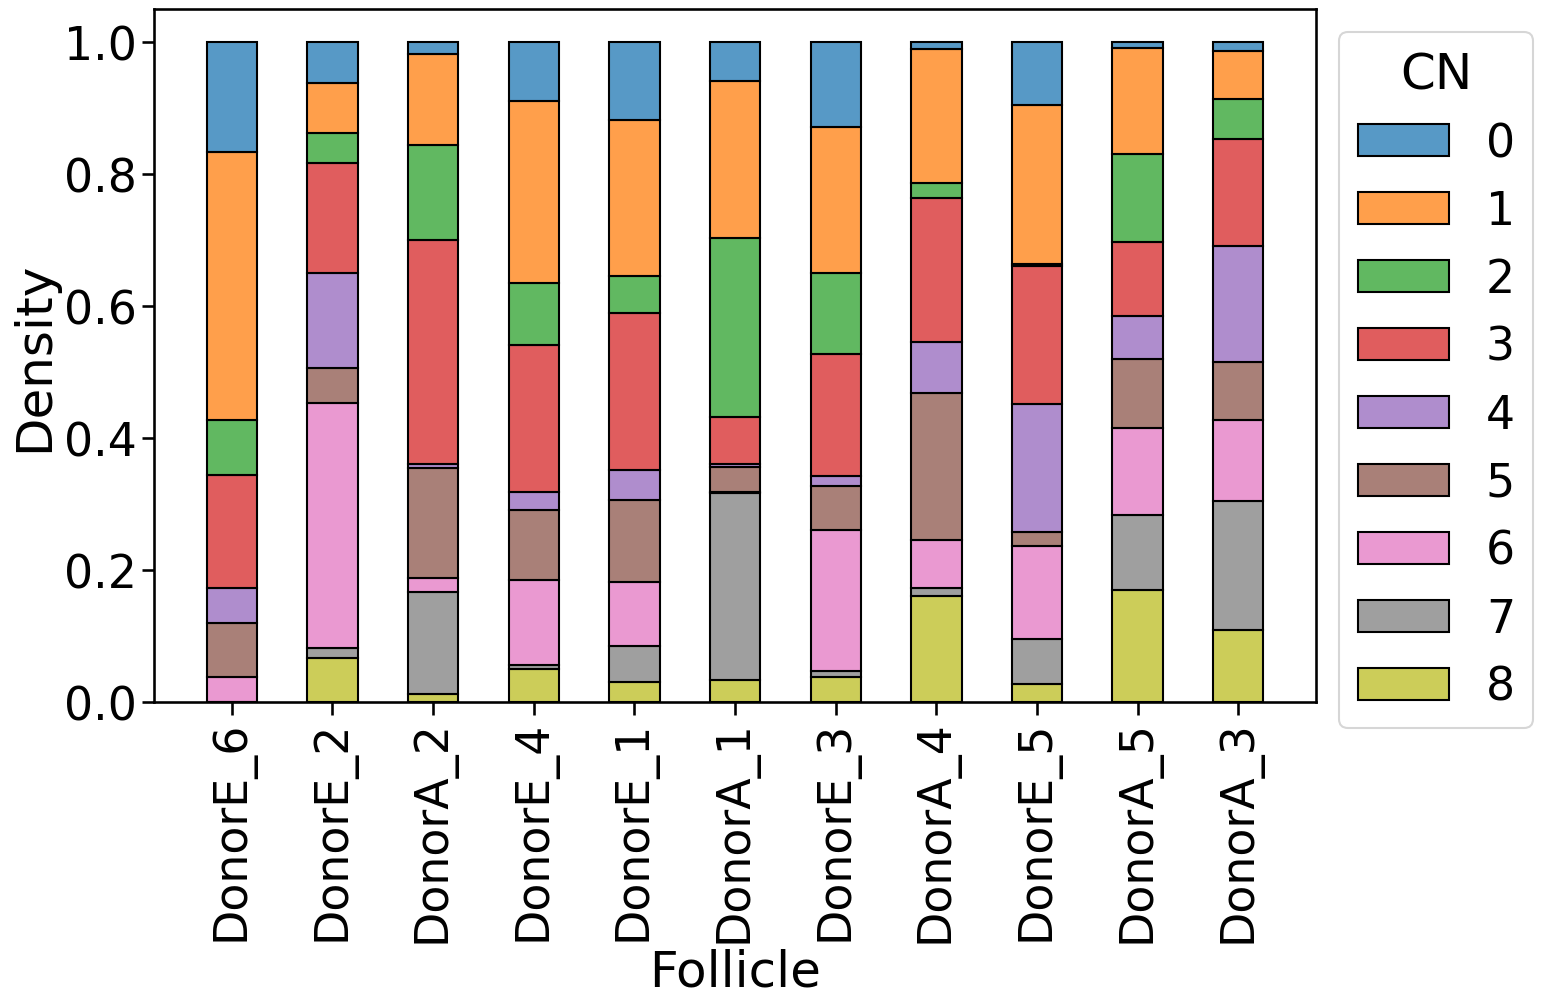

In [338]:
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax = sns.histplot(data=df_cluster_count, x='Follicle' , hue='CN', weights='Density', discrete=True, multiple='stack', shrink=0.5, palette=colors_rgb_dict, edgecolor='k',)
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))
    plt.xticks(rotation=90)

    


# Plot cell mask

In [288]:
import matplotlib
import skimage


# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img

In [289]:
masks = get_masks(data_dir / "masks")

In [290]:
adata_count_dataset

AnnData object with n_obs × n_vars = 9 × 11
    obs: 'CN'
    uns: 'dendrogram_CN', 'CN_colors'

In [307]:
import matplotlib 

var = 'Clusters'

cluster_label_order = adata_count.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_count.uns[f"{var}_colors"]
labels = adata_count.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}


In [308]:
len(cluster_label_order)

9

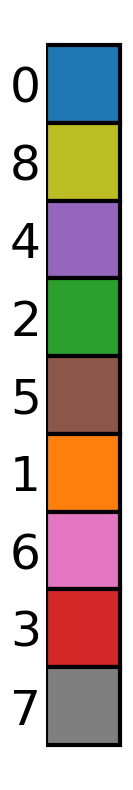

In [309]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,10))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [310]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [295]:
experiment = 'tonsil'

for dataset in datasets:
    print(dataset)
    try:
        adata_subset = adata[adata.obs.Dataset == dataset, :]
        mask = masks[experiment + '_' + dataset]
        print(len(adata_subset), len(np.unique(mask)))

    except:
        pass


DonorA_1
2711 2712
DonorE_1
3401 3402
DonorA_2
3047 3048
DonorE_2
2941 2942
DonorA_3
2107 2108
DonorE_3
3037 3038
DonorA_4
2885 2886
DonorE_4
3150 3151
DonorA_5
2540 2541
DonorE_5
2331 2332
DonorA_6
DonorE_6
3006 3007


DonorA_1
2711 2712


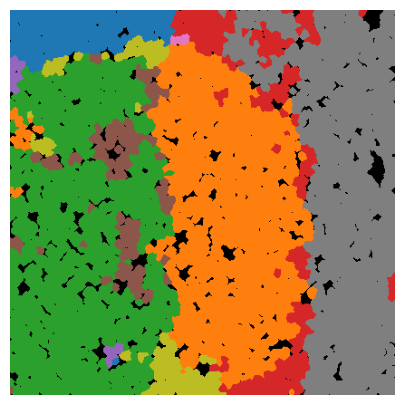

DonorE_1
3401 3402


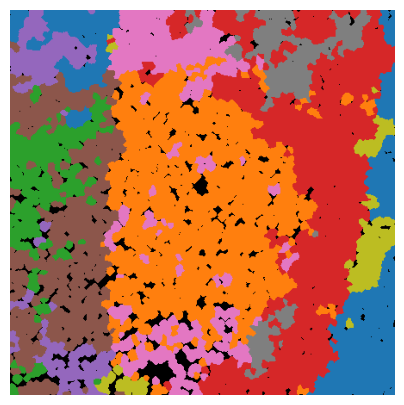

DonorA_2
3047 3048


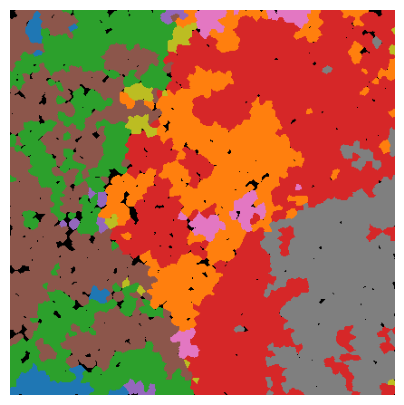

DonorE_2
2941 2942


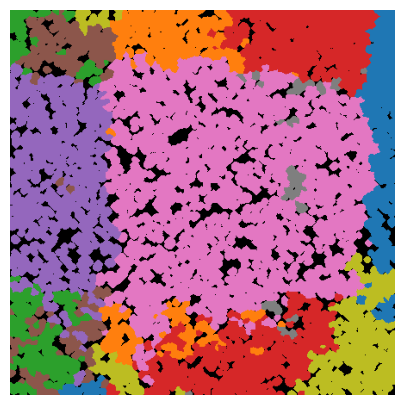

DonorA_3
2107 2108


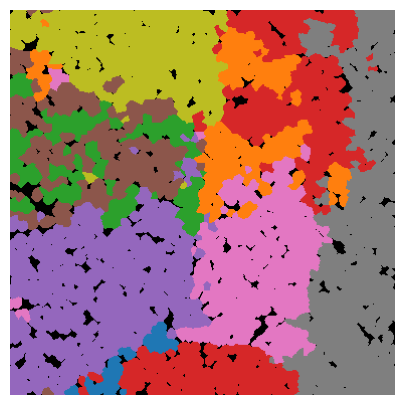

DonorE_3
3037 3038


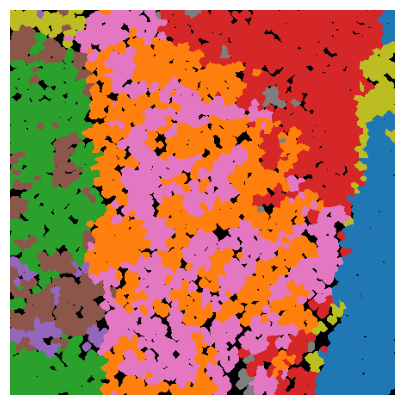

DonorA_4
2885 2886


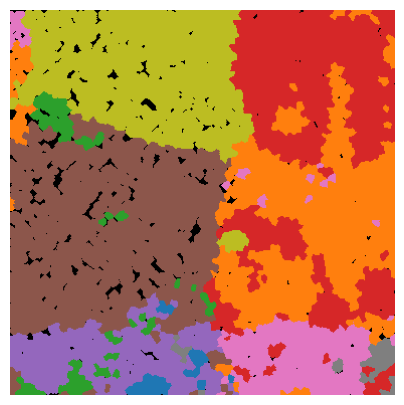

DonorE_4
3150 3151


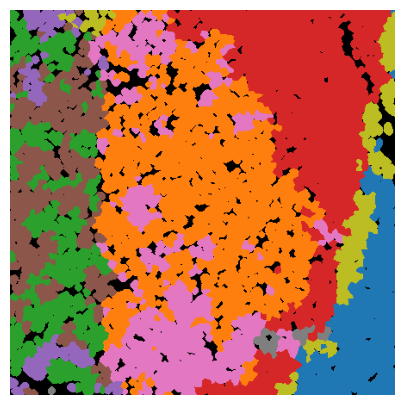

DonorA_5
2540 2541


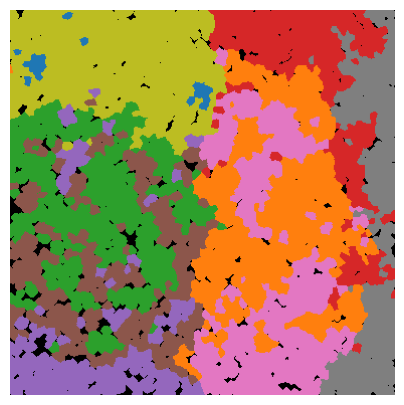

DonorE_5
2331 2332


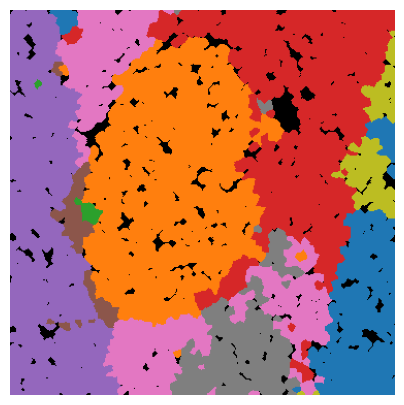

DonorA_6
DonorE_6
3006 3007


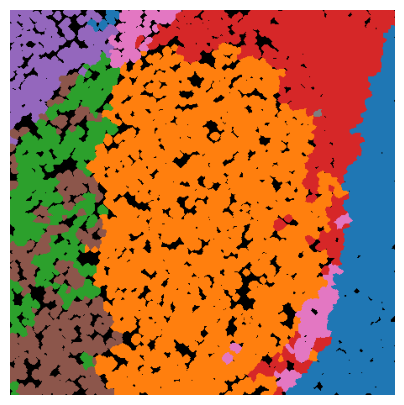

In [296]:
experiment = 'tonsil'

for dataset in datasets:
    print(dataset)
    try:
        adata_subset = adata_CN[adata_CN.obs.Dataset == dataset, :]
        mask = masks[experiment + '_' + dataset]
        print(len(adata_subset), len(np.unique(mask)))

        # Get label2cell dict
        label2cell = {}
        for l in labels:
            cell_id = adata_subset[adata_subset.obs.CN == l].obs.Cell.to_list()
            label2cell[l] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img)
        ax.axis("off")
        plt.show()
    except:
        pass
